## Precios de derivados

El objetivo de este estudio de caso es realizar precios derivados desde el punto de vista del aprendizaje automático y utilizar un modelo basado en regresión supervisada para aprender el modelo de precios de opciones de Black-Scholes a partir de datos simulados.


## Contenido

* [1. Definición del problema](#0)
* [2. Cargar libreria y conjunto de datos](#1)
    * [2.1. Cargar librerias](#1.1)    
    * [2.2. Definición de funciones y parámetros](#1.2)
    * [2.3. Cargar el dataset](#1.3)
* [3. Análisis exploratorio de datos](#2)
    * [3.1 Estadística descriptiva](#2.1)    
    * [3.2. Visualización de datos](#2.2)
* [4. Análisis y preparación de datos](#3)
    * [4.1.Selección de características](#3.1) 
* [5. Evaluación de modelos](#4)        
    * [5.1. Métricas de evaluación](#4.1)
    * [5.2. Comparación de modelos](#4.2)
* [6. Ajuste de modelos](#5)
* [7. Análisis adicional](#6)


<a id='0'></a>
# 1. Definición del problema

En el marco de regresión supervisada utilizado para este estudio de caso, el precio del derivado se define en el marco de regresión, donde la variable pronosticada es la el precio de la opción, y las variables predictoras son los datos de mercado que se utilizan como entradas al modelo de valoración de opciones de Black-Scholes

Las opciones se han utilizado en finanzas como medio para cubrir el riesgo de manera no lineal. También los utilizan los especuladores para realizar apuestas apalancadas en los mercados financieros. Históricamente, la gente ha usado la fórmula de Black Scholes.

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

Con

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

y

$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$

Donde se tiene
    Precio de la acción $S$;
    Precio de ejercicio de la opción de compra $K$;
    Tasa de interés sin riesgo $r$;
    Rentabilidad por dividendo anual $q$;
    Tiempo de maduración $\tau = T-t$ (representado como una fracción sin unidades de un año);
    Volatibilidad $\sigma$

Para simplificar la lógica, se define *Moneyness* como $M = K/S$ y se miran los precios en términos de por unidad del precio actual de las acciones. También ponemos $q$ como $0$ 

Esto simplifica la fórmula como

$$  e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$

### Volatibilidad

En el mercado de opciones, no hay un solo valor de volatilidad que nos dé el precio correcto. A menudo encontramos la volatilidad tal que la salida coincide con el precio

### Simulación

En este ejercicio se asume una estructura para la volatibilidad. En la práctica, nosotros traeriamos estos datos de una fuente. 

$$ \sigma(M, \tau) = \sigma_0 + \alpha\tau + \beta (M - 1)^2$$

<a id='1'></a>
# 2. Cargar librerias y conjunto de datos

<a id='1.1'></a>
## 2.1. Cargar librerias

In [1]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Definición de funciones y parámetros

In [3]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2

In [4]:
risk_free_rate = 0.05

### Funciones de volatilidad y precio de derivado

In [5]:
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha * time_to_maturity + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

<a id='1.3'></a>
## 2.3. Generación de datos

In [6]:
N = 10000

Ks = 1+0.25*np.random.randn(N)
Ts = np.random.random(N)
Sigmas = np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

### Datos exógenos y endógenos

In [7]:
Y = Ps

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

<a id='2'></a>
# 3. Análisis exploratorio de datos

<a id='2.1'></a>
## 3.1. DeEstadística descriptiva

In [8]:
dataset.head()

,Price,Moneyness,Time,Vol
0,0.210495,0.982586,0.752285,0.275259
1,0.335102,0.742261,0.820825,0.288725
2,0.208469,1.103892,0.957957,0.296875
3,0.042059,1.010099,0.074300,0.207440
4,0.169086,1.159747,0.867431,0.289295


In [11]:
pd.set_option("display.precision", 3)
dataset.describe()

,Price,Moneyness,Time,Vol
count,10000.000,10000.000,1.000e+04,10000.000
mean,0.178,0.999,5.016e-01,0.256
std,0.135,0.248,2.887e-01,0.030
min,0.000,0.052,3.307e-05,0.200
25%,0.076,0.834,2.513e-01,0.231
50%,0.161,1.001,5.008e-01,0.256
75%,0.253,1.169,7.523e-01,0.281
max,0.949,2.020,9.999e-01,0.366


<a id='2.2'></a>
## 3.2. Visualización de datos

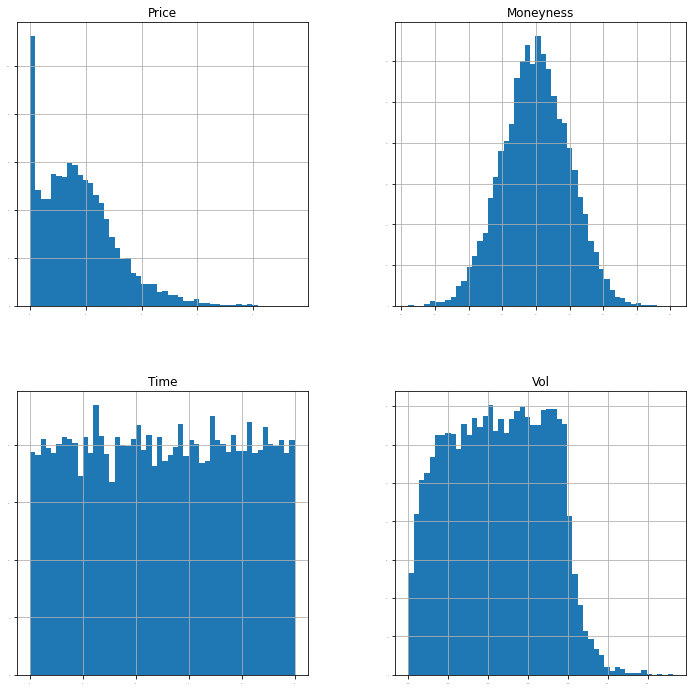

In [12]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

Se puede observar que el precio tiene una distribución interesante con un pico en $0$

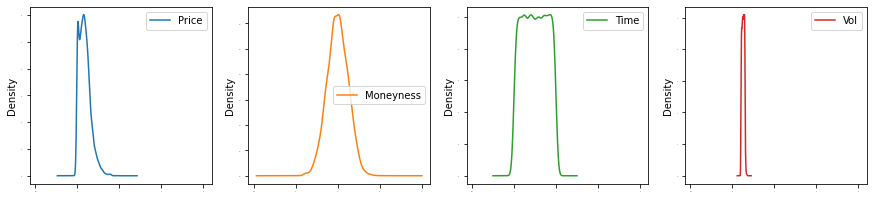

In [13]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

Ahora podemos observar la relación entre las diferentes variables

<AxesSubplot:title={'center':'Correlation Matrix'}>

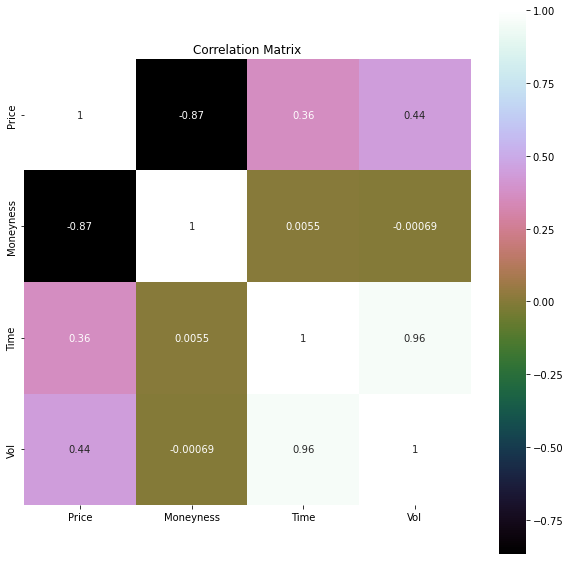

In [43]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

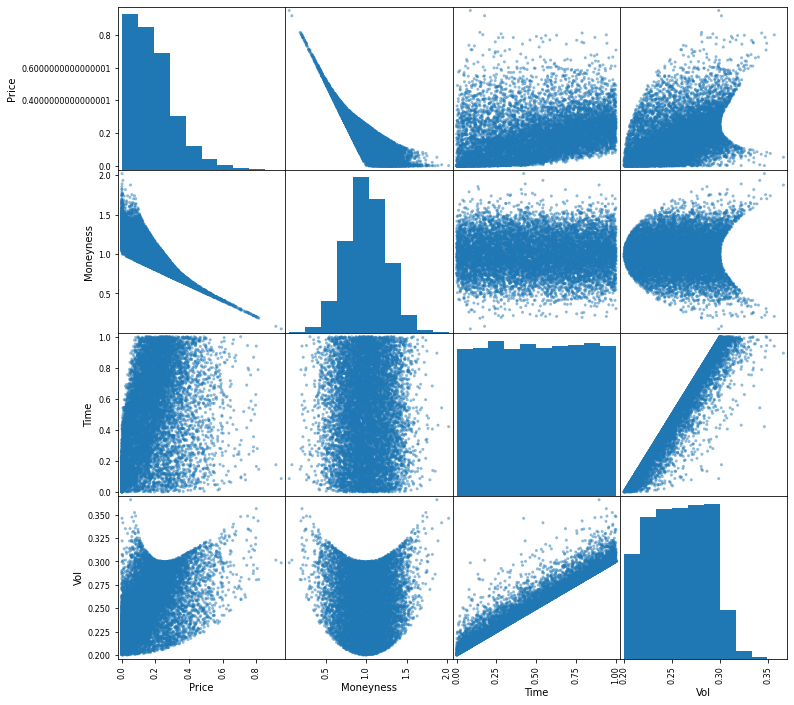

In [15]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Se puede observar un comportamiento nonlineal interesante entre las diferentes variables. Esto significa que se espera que los modelos no lineales se comporten mucho mejor

<a id='3'></a>
## 4. Análisis y preparación de datos

<a id='4.1'></a>
## 4.1. Selección de características

Se usará la función SelectKBest de la libreria de `sklearn`

In [16]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Moneyness,30207.228
Vol,2418.533
Time,1515.939


Observamos que *"Moneyness"* es la característica mas importante para la predicción del precio

<a id='4'></a>
# 5. Evaluación de modelos

<a id='4.1'></a>
## 5.1. Métricas de evaluación

In [17]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [18]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

<a id='4.2'></a>
## 5.2. Comparación de modelos y algoritmos

#### Modelos lineales y arboles de regresión

In [19]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#### Predictor usando redes neuronales

In [20]:
models.append(('MLP', MLPRegressor()))

#### Métodos de Boosting y Bagging

In [21]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [27]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000348 (0.000020) 0.000348 0.000359
LASSO: 0.018188 (0.000964) 0.018186 0.018365
EN: 0.018188 (0.000964) 0.018186 0.018365
KNN: 0.000017 (0.000011) 0.000009 0.000011
CART: 0.000011 (0.000005) 0.000000 0.000009
SVR: 0.004994 (0.000082) 0.004952 0.004919
MLP: 0.000028 (0.000013) 0.000021 0.000022
ABR: 0.000717 (0.000047) 0.000706 0.000697
GBR: 0.000021 (0.000001) 0.000015 0.000018
RFR: 0.000003 (0.000002) 0.000000 0.000002
ETR: 0.000001 (0.000001) 0.000000 0.000000


Realizemos una gráfica para mirar y hacer un análisis

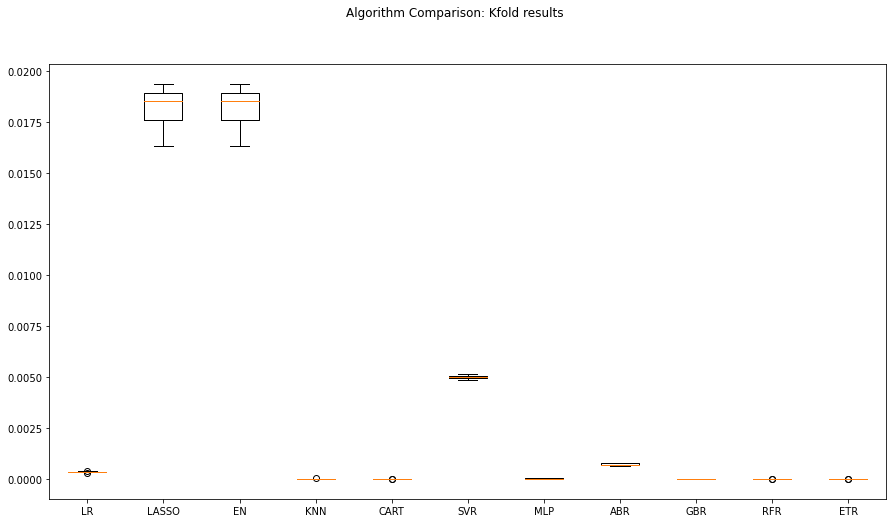

In [28]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

Podemos remover LASSO y Elastic para mirar mejor

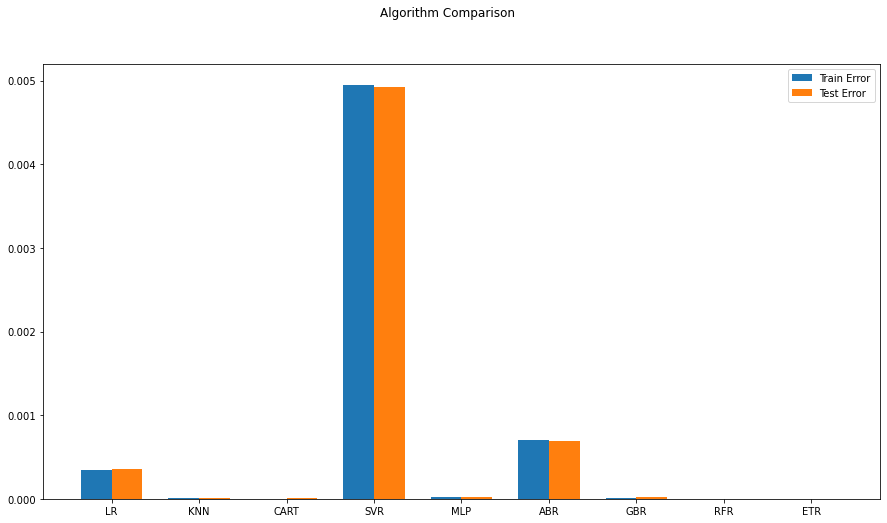

In [29]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()

Vemos que el algoritmo de perceptrón multicapa (MLP) funciona mucho mejor que el algoritmo lineal. Sin embargo, los métodos CART y Forest también hacen un muy buen trabajo. Dado que MLP es uno de los mejores modelos, realizamos la búsqueda en cuadrícula del modelo MLP en el siguiente paso.

<a id='5'></a>
# 6. Ajuste de hiperparámetros

Como se muestra en el gráfico anterior, el modelo MLP es uno de los mejores, por lo que se realizará ajuste de hiperparámetros. Realizamos una búsqueda en cuadrícula con diferentes combinaciones de capas ocultas en el modelo MLP.

In [44]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000040 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000550 (0.000638) with: {'hidden_layer_sizes': (20,)}
-0.000209 (0.000202) with: {'hidden_layer_sizes': (50,)}
-0.000060 (0.000036) with: {'hidden_layer_sizes': (20, 20)}
-0.000040 (0.000022) with: {'hidden_layer_sizes': (20, 30, 20)}


El mejor modelo es el modelo de 3 capas con 20, 30 y 20 nodos en cada capa respectivamente.

In [32]:
# prepare model
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model_tuned.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [ ]:
# estimate accuracy on validation set
# transform the validation dataset
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

Vemos que el error medio (RMSE) es muy bajo. Por lo tanto, el modelo de aprendizaje  hace un excelente trabajo al adaptarse al modelo de valoración de opciones de Black-Scholes. La precisión puede mejorarse con más afinación.

<a id='6'></a>
# 7. Análisis adicional: remover volatibilidad en los datos

A continuación, hacemos el proceso más difícil tratando de predecir el precio sin los datos de volatilidad.

In [33]:
X = X[:, :2]

In [34]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [35]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

In [36]:
models = []
models.append(('LR', LinearRegression()))
#models.append(('LASSO', Lasso()))
#models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [37]:
models.append(('MLP', MLPRegressor()))

In [38]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [40]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.002075 (0.000145) 0.002072 0.002054
KNN: 0.000018 (0.000011) 0.000009 0.000011
CART: 0.000010 (0.000001) 0.000000 0.000008
SVR: 0.005839 (0.000085) 0.005803 0.005724
MLP: 0.000043 (0.000030) 0.000026 0.000023
ABR: 0.000755 (0.000058) 0.000646 0.000649
GBR: 0.000022 (0.000002) 0.000015 0.000018
RFR: 0.000003 (0.000002) 0.000000 0.000002
ETR: 0.000001 (0.000001) 0.000000 0.000000


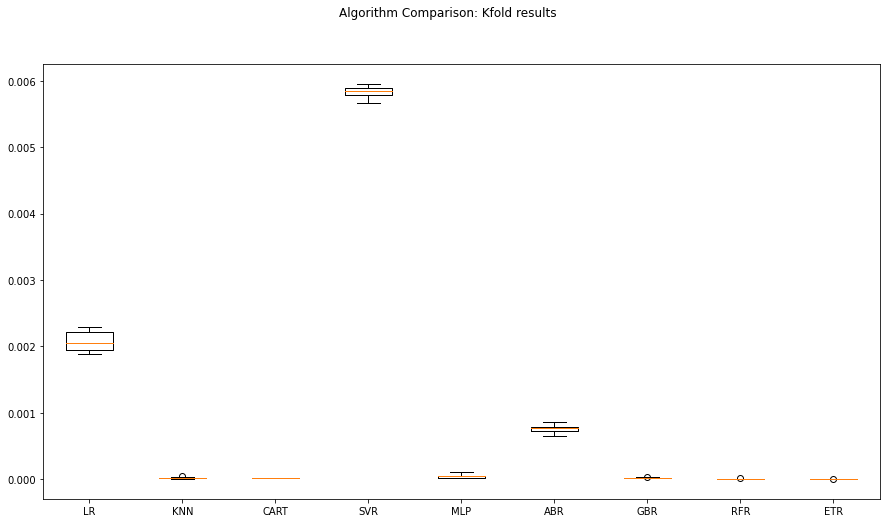

In [41]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

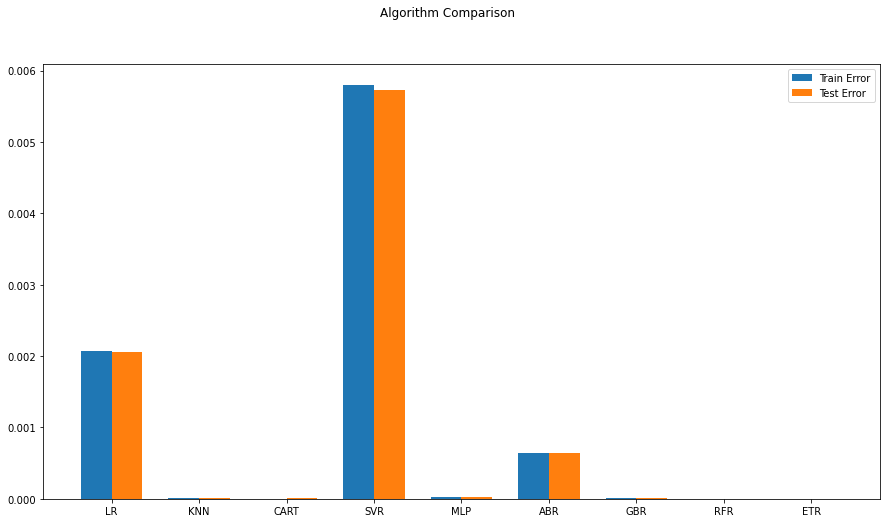

In [42]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Podemos ver que la regresión lineal ahora hace un peor trabajo que antes, esto es de esperar ya que hemos agregado una mayor cantidad de no linealidad.

### Resumen

* El modelo de regresión lineal no funcionó tan bien como nuestros modelos no lineales y los modelos no lineales tienen un muy buen desempeño en general.

* La red neuronal artificial (ANN) puede reproducir la fórmula de fijación de precios de opciones de Black and Scholes para una opción de compra con un alto grado de precisión, lo que significa que podemos aprovechar el cálculo numérico eficiente del aprendizaje automático en la fijación de precios derivados sin depender de las suposiciones.